# From Gunes

In [3]:
import sys
import os
import re
import pandas as pd
import numpy as np

from os.path import dirname, realpath, join, isfile
#from nb_common import POLICY_TEXT_PICKLE, DEDUPED_POLICY_TEXT_PICKLE

sys.path.append(join(dirname(os.getcwd()),'src'))
#from common import POLICY_DB_PATH, POLICY_CRAWL_LOG_MSGS_PICKLE, ROOT_DATA_DIR
#from utils import connect_to_db

In [4]:
DEDUPED_POLICY_TEXT_PICKLE = "../data/deduped_policy_text_v11no_html_with_links_and_emails.pickle"

In [5]:
%load_ext autoreload
%autoreload 2

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

DEFAULT_START_YEAR = 2000
DEFAULT_PLOT_COLOR = "steelblue"
INTERVAL_COL_NAME = "year_season"
DEFAULT_MIN_YEAR = 2009

In [7]:
df = pd.read_pickle(DEDUPED_POLICY_TEXT_PICKLE)

In [8]:
from nb_trending import add_rank_bins_to_df, RANK_BIN_LABELS

In [9]:
add_rank_bins_to_df(df)

In [10]:
site_intervals = df.sort_values("year_season").groupby('site_url')['year_season'].agg(list).to_dict()

In [11]:
def get_year_from_interval(interval):
    return int(curr_interval.split("_")[0])

def get_season_from_interval(interval):
    return curr_interval.split("_")[-1]

def get_interval_diff(curr_interval, last_interval):
    assert curr_interval > last_interval
    curr_year, curr_season = curr_interval.split('_')
    last_year, last_season = last_interval.split('_')
    year_diff = int(curr_year) - int(last_year)
    if last_season == curr_season:  # A and A, or B and B
        season_diff = 0
    elif curr_season > last_season:  # B and A
        season_diff = 1
    else:    # A and B
        season_diff = -1

    return season_diff + 2*year_diff

def get_gap(site_url, curr_interval):
    intervals = site_intervals[site_url]
    index = intervals.index(curr_interval)
    if not index:
        return None
    last_interval = intervals[index-1]
    interval_diff = get_interval_diff(curr_interval, last_interval)
    return interval_diff - 1


In [12]:
%%time
df['gap_before'] = df.parallel_apply(lambda row: get_gap(row['site_url'], row['year_season']), axis=1)

CPU times: user 12.1 s, sys: 39.5 s, total: 51.6 s
Wall time: 56.3 s


In [13]:
df['gap_before'].value_counts().head(5)

0.0    690918
1.0     59323
2.0     19971
3.0     10103
4.0      5834
Name: gap_before, dtype: int64

In [16]:
from collections import Counter
from tqdm import tqdm
import difflib
from collections import Counter
import simhash

d = difflib.Differ()

SIMHASH_THRESHOLD = 3

def get_diff_results(text1, text2):
    text1_lines = text1.splitlines()
    text2_lines = text2.splitlines()
    diff_results = dict(Counter([l[:2] for l in d.compare(text1_lines, text2_lines)]))
    diff_results['previous_policy_n_lines'] = len(text1_lines)
    diff_results['policy_n_lines'] = len(text2_lines)
    return diff_results

def mark_updated_policies(df):
    strict_updated = set()
    simhash_updated = set()

    last_sha1s = {}
    last_simhashes = {}
    last_texts = {}
    diffs = {}

    for index, row in tqdm(df.sort_values('year_season').iterrows(),total=len(df)):
        site_url = row['site_url']
        curr_simhash = row['simhash']
        curr_sha1 = row['sha1']
        gap_before = row['gap_before']
        policy_text = row['policy_text']
        homepage_snapshot_url = row['homepage_snapshot_url']

        last_sha1 = last_sha1s.get(site_url)
        if gap_before == 0 and last_sha1 is not None and last_sha1 != curr_sha1:
            strict_updated.add(homepage_snapshot_url)
            last_text = last_texts.get(site_url)
            diffs[homepage_snapshot_url] = get_diff_results(last_text, policy_text)

        last_sha1s[site_url] = curr_sha1
        last_texts[site_url] = policy_text

        last_simhash = last_simhashes.get(site_url)
        if gap_before == 0 and last_simhash is not None and simhash.num_differing_bits(last_simhash, curr_simhash) > SIMHASH_THRESHOLD:
            simhash_updated.add(homepage_snapshot_url)
        last_simhashes[site_url] = curr_simhash

    df['strict_updated'] = df.homepage_snapshot_url.isin(strict_updated)
    df['simhash_updated'] = df.homepage_snapshot_url.isin(simhash_updated)
    df['diff_result'] = df.homepage_snapshot_url.map(lambda x: diffs.get(x))


In [17]:
mark_updated_policies(df)


100%|██████████| 910546/910546 [2:59:07<00:00, 84.72it/s]    


In [18]:
def get_diff_percent(diff_result, opcode):
    if diff_result is None:
        return 0
    previous_policy_n_lines = diff_result['previous_policy_n_lines']
    return 100*diff_result.get(opcode, 0) / previous_policy_n_lines

df['increased'] = df.diff_result.map(lambda x: get_diff_percent(x, "+ "))
df['decreased'] = df.diff_result.map(lambda x: get_diff_percent(x, "- "))
df['inline_update'] = df.diff_result.map(lambda x: get_diff_percent(x, "? "))
df['common'] = df.diff_result.map(lambda x: get_diff_percent(x, "  "))

In [19]:
df.to_pickle('temp.pickle')

In [20]:
! ls -lthr temp.pickle

-rw-r--r--. 1 rbamos grad 7.6G Nov 29 13:48 temp.pickle


<AxesSubplot:xlabel='Interval', ylabel='ss'>

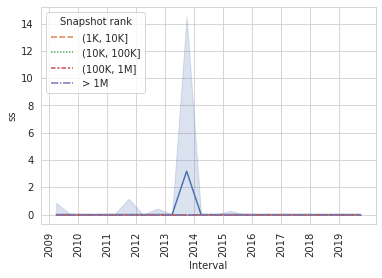

In [21]:
from nb_trending import lineplot_per_interval
lineplot_per_interval(df, y='increased', hue='binned_rank', y_title="ss",
        start_year=2009, save_to_file=True, filetype="pdf",
        legend_loc="upper left", hue_order=RANK_BIN_LABELS)

<AxesSubplot:xlabel='Interval', ylabel='decreased'>

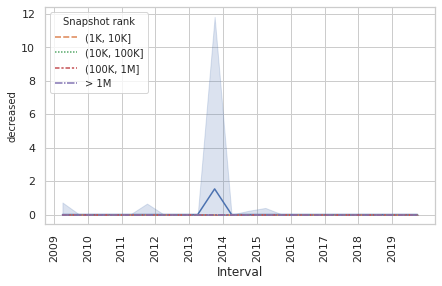

In [22]:
from nb_trending import lineplot_per_interval
lineplot_per_interval(df, y='decreased', hue='binned_rank', y_title="decreased",
        start_year=2009, save_to_file=True, filetype="pdf",
        legend_loc="upper left", hue_order=RANK_BIN_LABELS)

<AxesSubplot:xlabel='Interval', ylabel='common'>

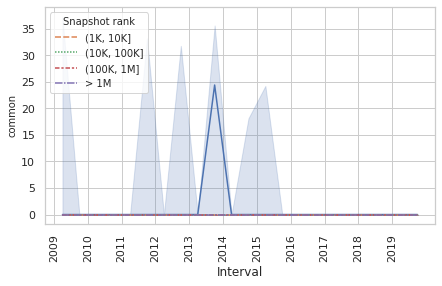

In [23]:
from nb_trending import lineplot_per_interval
lineplot_per_interval(df, y='common', hue='binned_rank', y_title="common",
        start_year=2009, save_to_file=True, filetype="pdf",
        legend_loc="upper left", hue_order=RANK_BIN_LABELS)

In [24]:
df.strict_updated.value_counts(), df.simhash_updated.value_counts()

(False    733043
 True     177503
 Name: strict_updated, dtype: int64,
 False    803469
 True     107077
 Name: simhash_updated, dtype: int64)

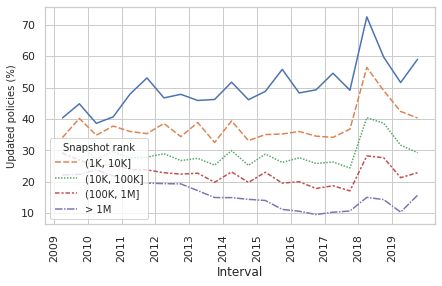

In [25]:
from nb_trending import lineplot_top_x_in_time, lineplot_percentages_by_factor_and_binned_rank

g = lineplot_percentages_by_factor_and_binned_rank(
    df[df.gap_before==0], "strict_updated",
    y_title="Updated policies (%)",
    legend_loc="lower left"
)


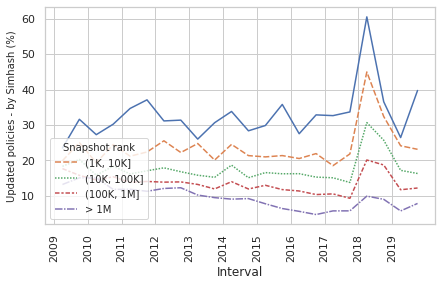

In [26]:
from nb_trending import lineplot_top_x_in_time, lineplot_percentages_by_factor_and_binned_rank

g = lineplot_percentages_by_factor_and_binned_rank(
    df[df.gap_before==0], "simhash_updated",
    y_title="Updated policies - by Simhash (%)",
    legend_loc="lower left"
)


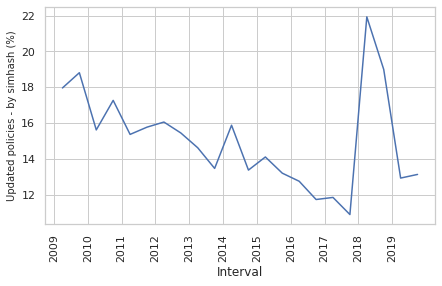

In [27]:
from nb_trending import lineplot_percentages_by_factor_and_binned_rank

g = lineplot_percentages_by_factor_and_binned_rank(
    df[df.gap_before==0], "simhash_updated",
    min_year=2009, y_title="Updated policies - by simhash (%)",
    legend_loc="lower left", by_rank=False
)


In [28]:
df['num_lines'] = df.policy_text.map(lambda x: len(x.split("\n")))

<AxesSubplot:xlabel='Interval', ylabel='Num. of external link domains (mean)'>

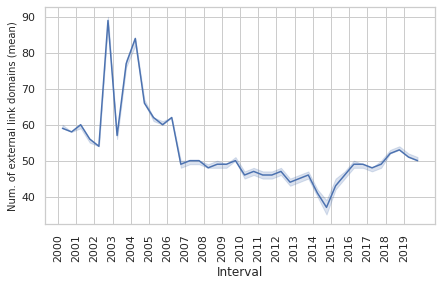

In [29]:
from nb_trending import lineplot_per_interval
lineplot_per_interval(df, y='num_lines', hue=False, y_title="Num. of external link domains (mean)",
        start_year=2000, save_to_file=True, filetype="pdf",
        legend_loc="upper left", hue_order=RANK_BIN_LABELS)

<AxesSubplot:xlabel='Interval', ylabel='Num. of external link domains (mean)'>

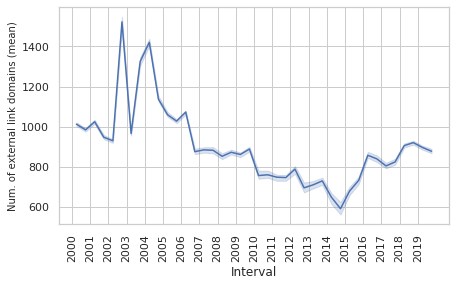

In [30]:
from nb_trending import lineplot_per_interval
lineplot_per_interval(df, y='word_count', hue=False, y_title="Num. of external link domains (mean)",
        start_year=2000, save_to_file=True, filetype="pdf",
        legend_loc="upper left", hue_order=RANK_BIN_LABELS)

<AxesSubplot:xlabel='Interval', ylabel='Num. of external link domains (mean)'>

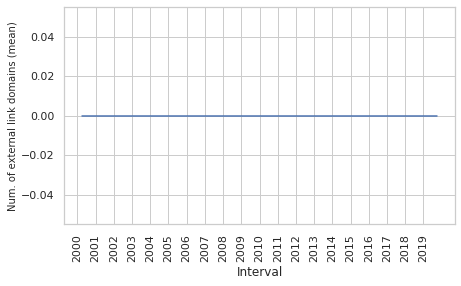

In [31]:
from nb_trending import lineplot_per_interval
lineplot_per_interval(df, y='gap_before', hue=False, y_title="Num. of external link domains (mean)",
        start_year=2000, save_to_file=True, filetype="pdf",
        legend_loc="upper left", hue_order=RANK_BIN_LABELS)

<AxesSubplot:xlabel='Interval', ylabel='Num. of gaps before(mean)'>

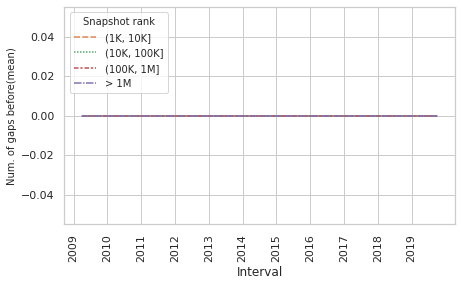

In [32]:
from nb_trending import lineplot_per_interval
lineplot_per_interval(df, y='gap_before', hue='binned_rank', y_title="Num. of gaps before(mean)",
        start_year=DEFAULT_MIN_YEAR, save_to_file=True, filetype="pdf",
        legend_loc="upper left", hue_order=RANK_BIN_LABELS)

In [33]:
assert 0 == len(df[(df.gap_before!=0) & (df.simhash_updated)])

In [34]:
assert 0 == len(df[(df.gap_before!=0) & (df.strict_updated)])

In [35]:

def print_update_stats(df, interval):
    slice = df[df.year_season==interval]
    return len(slice), len(slice[slice.gap_before==0]), len(slice[slice.strict_updated]), len(slice[slice.simhash_updated])


In [36]:
print_update_stats(df, '2017_B')

(33460, 27355, 5346, 2981)

In [37]:
print_update_stats(df, '2018_A')

(26410, 21114, 6315, 4630)

In [38]:

pd.set_option("display.max_colwidth", 500)
pd.set_option("display.max_rows", 500)